# Implementation

In [ ]:
import torch
import torch.nn as tnn
import torchvision as tvision
import torch.optim as toptim

import matplotlib.pyplot as plt

In [ ]:
# Setup a config parameter for automaticaly choosing between CPU/GPU compute depending on whether a NVIDIA CUDA capable GPU is present
COMPUTE_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.device(COMPUTE_DEVICE)

In [ ]:
# Setup dataset parameters and training hyperparameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 1000
MEAN = 0.5
STD_DEV = 0.5
EPOCHS = 20
BASE_LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.1
LEARNING_RATE_STEP_SIZE = 2

In [ ]:
# Calculate the mean and std dev from the dataset
train_set = tvision.datasets.MNIST(root="./trainingdata", train=True, transform=tvision.transforms.ToTensor(), download=True)

flattened_data = torch.stack([img for img, _ in train_set])

MEAN = flattened_data.view(1, -1).mean(dim=1).item()
STD_DEV = flattened_data.view(1, -1).std(dim=1).item()

print(f"MEAN: {MEAN}")
print(f"STD_DEV: {STD_DEV}")

In [ ]:
train_transforms = tvision.transforms.Compose(
    [
        tvision.transforms.ToTensor(),
        tvision.transforms.RandomRotation(90),
        tvision.transforms.Normalize(MEAN, STD_DEV)
    ]
)

eval_transforms = tvision.transforms.Compose(
    [
        tvision.transforms.ToTensor(),
        tvision.transforms.Normalize(MEAN, STD_DEV)
    ]
)

In [ ]:
# Load the dataset
training_set = tvision.datasets.MNIST(root="./trainingdata", train=True, transform=train_transforms, download=True)
evaluation_set = tvision.datasets.MNIST(root="./evaluationdata", train=False, transform=eval_transforms, download=True)

training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
evaluation_set_loader = torch.utils.data.DataLoader(evaluation_set, batch_size=EVAL_BATCH_SIZE, shuffle=False)

In [ ]:
# Get a copy of the data loader so that it can be iterated without affecting the model
train_set_imgs, train_set_labels = next(iter(training_set_loader))

# Display a few samples

plt.figure(figsize=(10, 10))

for i in range(20):
    img = train_set_imgs[i]
    lbl = train_set_labels[i]

    plt.subplot(5, 5, i + 1)
    plt.xlabel(f"Num: {lbl}")
    plt.imshow(img.numpy().squeeze(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [ ]:
# Setup the model layers
model = tnn.Sequential(
    tnn.Conv2d(1, 32, 3, 1, 1),
    tnn.BatchNorm2d(32),
    tnn.ReLU(),
    tnn.MaxPool2d(2, 2),

    tnn.Conv2d(32, 64, 3, 1, 1),
    tnn.BatchNorm2d(64),
    tnn.ReLU(),
    tnn.MaxPool2d(2, 2),

    tnn.Flatten(),
    tnn.Linear(64 * 7 * 7, 128), # img is 7x7 after going through two 2x2 pooling layers, multiplied then by the number of feature layers
    tnn.ReLU(),
    tnn.Dropout(0.2),
    tnn.Linear(128, 10)
).to(COMPUTE_DEVICE)

In [ ]:
# Setup optimizer, loss and learning rate scheduler functions
loss_func = tnn.CrossEntropyLoss()
optimizer = toptim.Adam(model.parameters(), lr=BASE_LEARNING_RATE)
lr_sched = toptim.lr_scheduler.StepLR(optimizer=optimizer, gamma=LEARNING_RATE_GAMMA, step_size=LEARNING_RATE_STEP_SIZE)

In [12]:
# Model training
for epoch in range(EPOCHS):
    # Switch to train mode, drops nodes etc
    model.train()

    epoch_loss = 0.0

    for img_batch, lbl_batch in training_set_loader:
        # Send the data to the GPU if one is available
        img_batch = img_batch.to(COMPUTE_DEVICE)
        lbl_batch = lbl_batch.to(COMPUTE_DEVICE)

        optimizer.zero_grad()

        batch_outputs = model(img_batch)
        batch_loss = loss_func(batch_outputs, lbl_batch)

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

    lr_sched.step()
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"Loss: {epoch_loss}/{len(training_set_loader)}")
    print(f"Learning Rate: {lr_sched.get_last_lr()}")

Epoch: 1/20
Loss: 238.1430402668193/1875
Learning Rate: [1.0000000000000007e-13]
Epoch: 2/20
Loss: 238.17433638544753/1875
Learning Rate: [1.0000000000000008e-14]
Epoch: 3/20
Loss: 241.14338188851252/1875
Learning Rate: [1.0000000000000008e-14]
Epoch: 4/20
Loss: 236.77930071391165/1875
Learning Rate: [1.0000000000000009e-15]
Epoch: 5/20
Loss: 240.48671427322552/1875
Learning Rate: [1.0000000000000009e-15]
Epoch: 6/20
Loss: 241.59788199258037/1875
Learning Rate: [1.000000000000001e-16]
Epoch: 7/20
Loss: 241.5752761955373/1875
Learning Rate: [1.000000000000001e-16]
Epoch: 8/20
Loss: 239.26594388997182/1875
Learning Rate: [1.000000000000001e-17]
Epoch: 9/20
Loss: 236.54134415835142/1875
Learning Rate: [1.000000000000001e-17]
Epoch: 10/20
Loss: 239.55451058829203/1875
Learning Rate: [1.000000000000001e-18]
Epoch: 11/20
Loss: 238.06896029761992/1875
Learning Rate: [1.000000000000001e-18]
Epoch: 12/20
Loss: 240.204026612686/1875
Learning Rate: [1.000000000000001e-19]
Epoch: 13/20
Loss: 239.1


Final Test Accuracy: 97.71%


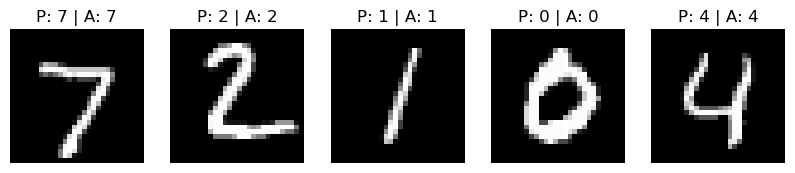

In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for img_batch, lbl_batch in evaluation_set_loader:
        img_batch = img_batch.to(COMPUTE_DEVICE)
        lbl_batch = lbl_batch.to(COMPUTE_DEVICE)

        batch_outputs = model(img_batch)
        prediction_confidence, predicted_class = torch.max(batch_outputs.data, 1)
        total_predictions += lbl_batch.size(0)
        correct_predictions += (predicted_class == lbl_batch).sum().item()

print(f"\nFinal Test Accuracy: {100 * correct_predictions / total_predictions:.2f}%")

img_batch, lbl_batch = next(iter(evaluation_set_loader))
img_batch, lbl_batch = img_batch.to(COMPUTE_DEVICE), lbl_batch.to(COMPUTE_DEVICE)
batch_outputs = model(img_batch)
_, preds = torch.max(batch_outputs, 1)

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(img_batch[i].cpu().squeeze(), cmap='gray')
    plt.title(f"P: {preds[i].item()} | A: {lbl_batch[i].item()}")
    plt.axis('off')
plt.show()